# Lab 4: North Celestial Pole

In [179]:
import numpy as np
import ugradio
import matplotlib.pyplot as plt
import pyfits
from astropy import units as u
from astropy.coordinates import SkyCoord
import glob
from itertools import chain
from scipy import signal
import scipy
from ugradio import leo
from ugradio import doppler
from scipy.interpolate import griddata

In [215]:
plt.rc('font',**{'family':'serif','serif':['cmr10'], 'size':12})
plt.rc('text', usetex=True)

In [4]:
def avg_spectrum(fits):
    """Takes in a fits file of power spectra and averages over all spectra using both polarization modes.
    
    Parameters
    ----------
    fits: fits file pre-loaded
    
    Returns
    -------
    avg_power : average power spectrum"""
    
    l = fits[0].header['L']
    b = fits[0].header['b']
    
    power_1 = []
    power_2 = []
    
    for i in range(len(fits)-1):
        pol_1 = fits[i+1].data['auto0_real']
        pol_2 = fits[i+1].data['auto1_real']
        power_1.append(pol_1)
        power_2.append(pol_2)
        
    power = power_1 + power_2

    avg_power = sum(power) / len(power)
    return l, b, avg_power

In [5]:
def avg(x):
    average = sum(x) / len(x)
    return average

## Calculating Column Density in a Velocity Range

In [19]:
H_line = 1420.4
LO = 633
freq_down = 1420.4 - 633*2
print 'Hydrogen line down-shifted to', freq_down, 'MHz ?'

Hydrogen line down-shifted to 154.4 MHz ?


In [13]:
x = pyfits.open('data_apr19_126.244987146_58.3025143334.fits')
x[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NSPEC   =                   15 / Number of spectra recorded                     
BOFFILE = 'spec_ds8_8192.bof'  / FPGA binary code                               
MODE    = 'spec    '           / Spectrometer mode                              
FPGA    =          192000000.0 / FPGA clock speed (Hz)                          
IADC    =          768000000.0 / iADC clock speed (Hz)                          
DOWNSAMP=                    8 / ADC downsampling period.                       
SAMPRATE=           24000000.0 / Downsampled clock speed (Hz)                   
BW      =           12000000.0 / Bandwidth of spectra (Hz)                      
NCHAN   =                 81

In [17]:
int_time = 0.6990506666666667
samples = 8192
t = int_time/samples

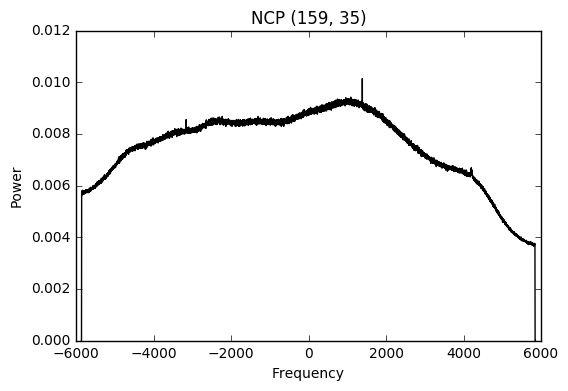

In [18]:
data = avg_spectrum(pyfits.open('data_apr19_126.244987146_58.3025143334.fits'))
data_ = data[2]

freq = np.fft.fftfreq(len(data_), t)
plt.plot(freq[len(freq)/2:], data_[:len(data_)/2], 'k')
plt.plot(freq[:len(freq)/2], data_[len(data_)/2:], 'k')
plt.title('NCP (159, 35)')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

In [40]:
ra = 126.244987146
dec = 58.3025143334
jd = 2458593.596006944
doppler.get_projected_velocity(ra, dec, jd, obs_lat=leo.lat, obs_lon=leo.lon, obs_alt=leo.alt, epoch=1546300800)

array([-23301.52254332])

Select a frequency range and convert to velocity range...

In [21]:
def velocity(freq):
    delta_freq = freq/1000 - 4.73
    v = - (delta_freq)/ (4.73) #km/s
    return v

In [84]:
def column_density(T_b, freq1, freq2):
    
    int_time = 0.6990506666666667
    samples = 8192
    t = int_time/samples
    
    freq = np.fft.fftfreq(len(T_b), t)
    delta_v = velocity(freq1) - velocity(freq2)
    
    index1 = np.min(np.where(freq > freq1))
    index2 = np.max(np.where(freq < freq2))
    
    N = 1.8e18 * T_b[index1:index2] * delta_v # cm-2
    avg_N = sum(N)/len(N)
    return avg_N

In [109]:
x = avg_spectrum(pyfits.open('data_apr19_126.244987146_58.3025143334.fits'))
x_ = np.array(x[2])/gain

column_density(x_, 4000., 4200.)

9.821960743734428e+18

## Making Maps

In [1]:
gain = 5.7936986306812226e-05

In [80]:
data1 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_date*.fits')],
        [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_date*.fits')],
        [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_date*.fits')]]

In [94]:
data2 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_may6*.fits')],
        [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_may6*.fits')],
        [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_may6*.fits')]]

In [128]:
data3 = [[avg_spectrum(pyfits.open(f))[0] for f in glob.glob('data_apr25*.fits')],
        [avg_spectrum(pyfits.open(f))[1] for f in glob.glob('data_apr25*.fits')],
        [avg_spectrum(pyfits.open(f))[2] for f in glob.glob('data_apr25*.fits')]]

In [129]:
l = [data1[0], data2[0], data3[0]]
longitude = np.array(list(chain.from_iterable(l)))

b = [data1[1], data2[1], data3[1]]
latitude = np.array(list(chain.from_iterable(b)))

all_data = []

for i in range(len(data1[2])):
    all_data.append(data1[2][i])
    
for i in range(len(data2[2])):
    all_data.append(data2[2][i]) 
    
for i in range(len(data3[2])):
    all_data.append(data3[2][i]) 

data = [longitude, latitude, all_data]

In [130]:
np.shape(all_data)

(473, 8192)

In [131]:
avg_data = []

for i in range(len(data[2])):
    avg = sum(data[2][i]) / len(data[2][i])
    avg_data.append(avg/gain)

In [202]:
missing_l = [119, 121, 121, 121, 121, 123, 123, 123, 123, 125, 125, 125, 127]
l_ = [data[0], missing_l]
longitude = np.array(list(chain.from_iterable(l_)))

missing_b = [ 27,  23, 25,  27,  29,  25,  27,  29,  31,  25,  27,  29,  27]
b_ = [data[1], missing_b]
latitude = np.array(list(chain.from_iterable(b_)))

missing_data = np.empty(((len(missing_l))))
missing_data[:] = np.nan
d_ = [avg_data, missing_data]
data_ = np.array(list(chain.from_iterable(d_)))

In [204]:
sorted_indices = np.argsort(longitude) # sorted longitude indices

sorted_data = [[], [], []] # sorted data based on longitude

for i in range(len(sorted_indices)):
    sorted_data[0].append(longitude[sorted_indices[i]])
    sorted_data[1].append(latitude[sorted_indices[i]])
    sorted_data[2].append(data_[sorted_indices[i]])

In [210]:
data_mod = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
# avg power grouped by latitude, ordered by longitude

for k in range(18):
    for i in range(len(sorted_data[1])):
        if sorted_data[1][i] > (14 + 2*k) and sorted_data[1][i] < (16 + 2*k):
            data_mod[k].append(sorted_data[2][i])

In [211]:
for i in range(len(data_mod)):
    while len(data_mod[i]) < 28:
        data_mod[i].append(np.nan)

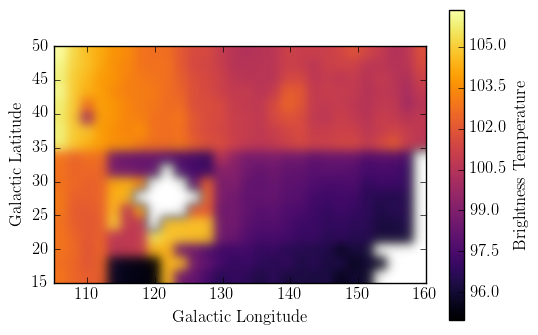

In [216]:
plt.figure()
plt.imshow(np.array(data_mod), cmap='inferno', interpolation='gaussian', aspect='equal', extent=[105,160,15,50], origin='lower')
cbar = plt.colorbar()
cbar.set_label('Brightness Temperature')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.show()

In [213]:
coord = []

for i in range(len(sorted_data[0])):
    lon = sorted_data[0][i]
    lat = sorted_data[1][i]
    coord.append([lon, lat])

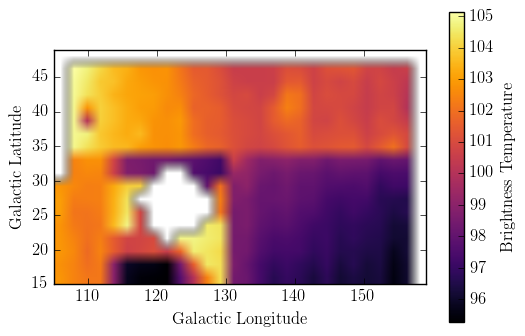

In [217]:
grid_x, grid_y = np.mgrid[105:159:28j, 15:49:18j]

grid_z = griddata(coord, sorted_data[2], (grid_x, grid_y))

plt.subplot(111)
plt.imshow(grid_z.T, cmap='inferno',extent=(105,159,15,49), origin='lower')
cbar = plt.colorbar()
cbar.set_label('Brightness Temperature')
plt.xlabel('Galactic Longitude')
plt.ylabel('Galactic Latitude')
plt.show()